# JMSR Ratio Plot

In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import mplhep as hep
import vector

import HH4b.utils as utils
from HH4b.utils import ShapeVar
import HH4b.plotting as plotting



In [2]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "PNetMass" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

## Load Dataset

In [3]:
year = "2022EE"  #
dir_name = "24Apr18_v12_signal"
path_to_dir = f"/eos/uscms/store/user/haoyang/bbbb/ttSkimmer/{dir_name}"

In [4]:
# Load your dataset
samples = {
    "muon": [
                "Muon_Run2022E",
                "Muon_Run2022F",
                "Muon_Run2022G",
            ],
    "tt": ["TTto2L2Nu", "TTto4Q", "TTtoLNu2Q"],
}

dirs = {path_to_dir: samples}

filters = None

# columns to load
# the parquet files are too big so we can only load a few columns at a time without consumming much memory
load_columns = [
    ("weight", 1),
    ("ak8FatJetMsd", 2),
    ("ak8FatJetPNetMass", 2),
    ("ak8FatJetEta", 2),
    ("ak8FatJetPhi", 2),
    ("ak8FatJetPt", 2),
    ("finalWeight", 0),
]
# reformat into ("column name", "idx") format for reading multiindex columns
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")


events_dict = {}
for input_dir, samples in dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(input_dir, samples, year, filters=filters, columns=columns),
    }

samples_loaded = list(events_dict.keys())
keys_loaded = list(events_dict[samples_loaded[0]].keys())
print(f"Keys in events_dict")
for i in keys_loaded:
    print(i)

Loaded Muon_Run2022E                                     : 20447 entries
Loaded Muon_Run2022F                                     : 65035 entries
Loaded Muon_Run2022G                                     : 10961 entries
Loaded TTto2L2Nu                                         : 808829 entries
Loaded TTto4Q                                            : 12835 entries
Loaded TTtoLNu2Q                                         : 3477904 entries
Keys in events_dict
('weight', 0)
('ak8FatJetMsd', 0)
('ak8FatJetMsd', 1)
('ak8FatJetPNetMass', 0)
('ak8FatJetPNetMass', 1)
('ak8FatJetEta', 0)
('ak8FatJetEta', 1)
('ak8FatJetPhi', 0)
('ak8FatJetPhi', 1)
('ak8FatJetPt', 0)
('ak8FatJetPt', 1)
('weight_nonorm', '')
('finalWeight', '')


## Event cuts

In [5]:
# Higgs candidate selection example
events_raw = pd.concat(
    [events_dict["muon"], events_dict["tt"]], keys=["muon", "ttbar"]
)

In [6]:
# AK4OutsideJet pt cut
# jets_outside_raw = make_vector(events_raw, "ak4JetOutside")
# j3_raw = jets_outside_raw[:, 0]
# j4_raw = jets_outside_raw[:, 1]
# j3j4_pt_cut = (j3_raw.pt > 20) & (j4_raw.pt > 20)

In [7]:
# combined_filter = j3j4_pt_cut
# events = events_raw[combined_filter]
events = events_raw

## Save and Reset Index

In [8]:
multiIndex = events.index
events = events.reset_index()

## Derive W jet mass

In [9]:
fatjets = make_vector(events, "ak8FatJet")
fj_sorted = np.take_along_axis(fatjets, np.argsort(fatjets.pt, axis=1)[:, ::-1], axis=1)
W_jets = fj_sorted[:,0]
W_jet_PNetMass = W_jets.m

In [10]:
events['WJetPNetMass'] = W_jet_PNetMass

## Set Index Back

In [11]:
events = events.set_index(multiIndex)

In [12]:
# parse the events df to a way that util can accept
events_dict = {}
events_dict['data'] = events.loc['muon']
events_dict['ttbar'] = events.loc['ttbar']

## Plot Mass

In [13]:
control_plot_vars = [
    ShapeVar(var="WJetPNetMass", label=r"W Jet PNet Mass (GeV)", bins=list(np.arange(20, 250, 5)), reg=False),
]

In [14]:
ylims = {
    "2022": 5e4,
    "2022EE": 4e3,
    "2023-pre-BPix": 4e5,
}


In [15]:
events_dict['data']["finalWeight"] = 1

/tmp/ipykernel_7386/985738304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_dict['data']["finalWeight"] = 1


In [16]:
events_dict['data']["finalWeight"]

0        1
1        1
2        1
3        1
4        1
        ..
10956    1
10957    1
10958    1
10959    1
10960    1
Name: finalWeight, Length: 96443, dtype: int64

ShapeVar(var='WJetPNetMass', label='W Jet PNet Mass (GeV)', bins=[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245], reg=False, blind_window=None, significance_dir='right', plot_args=None)


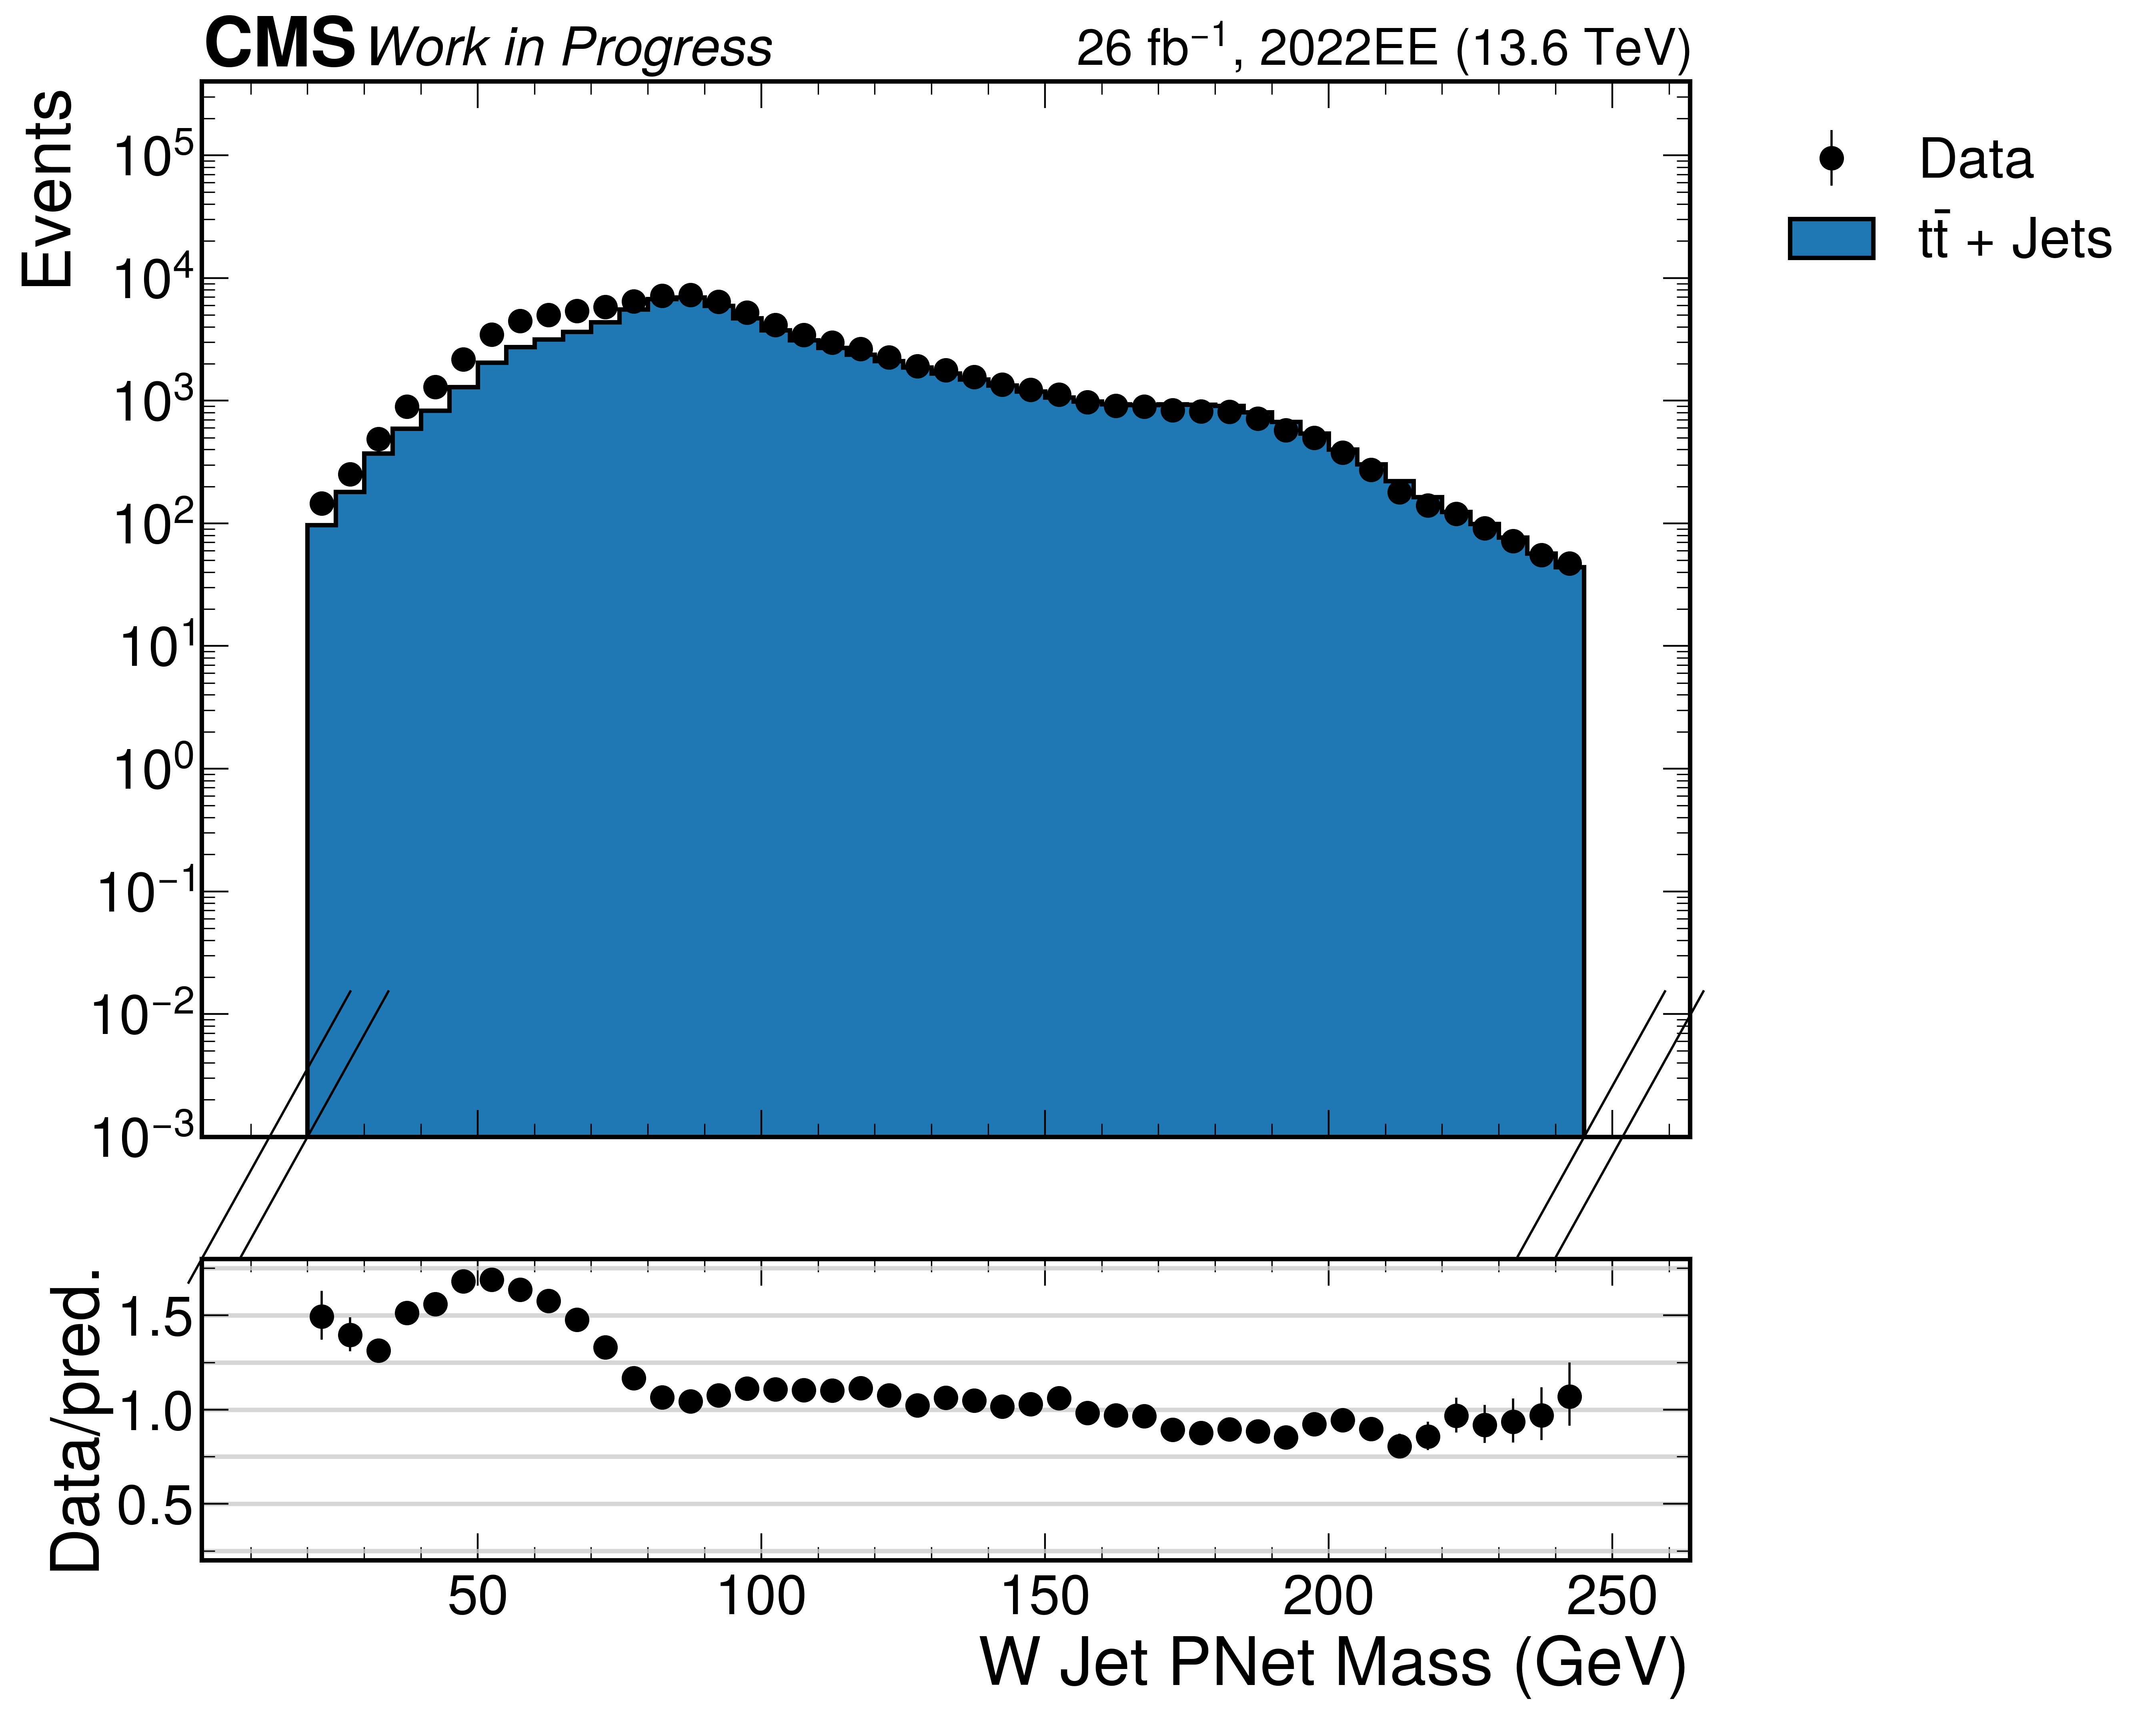

In [17]:
for year in ["2022EE"]:
    hists = {}
    for shape_var in control_plot_vars:
        print(shape_var)
        if shape_var.var not in hists:
            hists[shape_var.var] = utils.singleVarHist(
                events_dict,
                shape_var,
                weight_key="finalWeight",
            )

        bkgs = ["ttbar"]
        sigs = []

        plotting.ratioHistPlot(
            hists[shape_var.var],
            year,
            sigs,
            bkgs,
            name="test",
            show=True,
            log=True,
            plot_data=True,
            plot_significance=False,
            significance_dir=shape_var.significance_dir,
            ratio_ylims=[0.2, 1.8],
            ylim=4e5,
        )